In [70]:
import pandas as pd
import seaborn as sbs
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import ElasticNet

from sklearn.metrics import classification_report, plot_confusion_matrix, explained_variance_score,\
                            r2_score, mean_absolute_error, accuracy_score, f1_score

from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, LayerNormalization

In [6]:
def generate_np_data(data, col_x, col_y, look_back, predict_forward, N, categorize = False, zero_missing=True):
    X = []
    Y = []
    
    unique_location = data.wsnm.unique()
    
    dataframe_X = data[['wsnm'] + col_x]
    dataframe_Y = data[['wsnm'] + col_y]
    
    n_samples = 0
    last = -1
    
    for loc in unique_location:
        data_x = np.array(dataframe_X[dataframe_X.wsnm == loc].drop(columns=['wsnm']))
        data_y = np.array(dataframe_Y[dataframe_Y.wsnm == loc].drop(columns=['wsnm']))
        
        for i in range(len(data_x) - look_back - predict_forward):
            x_ = data_x[i:i+look_back]
            y_ = data_y[i+look_back - 1 + predict_forward]

            if not np.isnan(x_).any() and (not np.isnan(y_).any() or zero_missing):
                X.append(x_)
                n_samples += 1

                if zero_missing:
                    if np.isnan(y_).any():
                        Y.append(0)
                    elif categorize:
                        Y.append(1 if y_ > 0 else 0)
                    else:
                        Y.append(y_)
                else:
                    if categorize:
                        Y.append(1 if y_ > 0 else 0)
                    else:
                        Y.append(y_)
                        
            if n_samples % 5000 == 0 and n_samples != last:
                print(n_samples)
                last = n_samples
            if n_samples > N:
                 return np.array(X), np.array(Y)
 
    return np.array(X), np.array(Y)

In [7]:
def get_model_lstm(n_steps, n_features):
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(n_steps, n_features)))

    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics =['acc'])
    
    return model

In [76]:
def get_model_lstm_regression(n_steps, n_features, n_output):
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(n_steps, n_features)))
    
    model.add(Dense(n_output, activation = 'relu'))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics =['mse', 'mae'])
    
    return model

In [102]:
def cross_validate_lstm(X, Y, look_back, cv=10, reg=False):
    train_size = 1 - 1/cv
    results = []
    
    for _ in range(cv):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 1/cv)
        
        if reg:
            model = get_model_lstm_regression(look_back, X_train.shape[2], len(y_train.shape))
        else:
            model = get_model_lstm(look_back, X_train.shape[2])
        
        model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size=64, epochs=5)   
        
        if reg:
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
        
            results.append([r2, mae])     
        else:
            y_pred = model.predict(X_test) > 0.5
            f1 = f1_score(y_test, y_pred)
            acc = accuracy_score(y_test, y_pred)
        
            results.append([f1, acc])
    return results

In [95]:
def remove_min_max(array):
    return array[np.logical_and((array > array.min()), (array < array.max()))]

---

# Loading Data|

In [9]:
# https://www.kaggle.com/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region
data = pd.read_csv("sudeste.csv")

In [10]:
data.describe()

,wsid,elvt,lat,lon,yr,mo,da,hr,prcp,stp,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
count,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,9.779168e+06,1.407984e+06,9.779168e+06,...,9.779142e+06,9.778858e+06,9.779134e+06,9.778361e+06,9.779168e+06,9.779156e+06,9.779124e+06,8.853607e+06,9.779168e+06,9.462694e+06
mean,3.592531e+02,5.940923e+02,-2.023082e+01,-4.464590e+01,2.011164e+03,6.521960e+00,1.575465e+01,1.150000e+01,9.366544e-01,8.804292e+02,...,2.110503e+01,1.524025e+01,1.986418e+01,1.422089e+01,6.726667e+01,6.996991e+01,6.441965e+01,1.998156e+00,1.385991e+02,4.494015e+00
std,3.901630e+01,3.980379e+02,3.172643e+00,4.882117e+00,3.207774e+00,3.425538e+00,8.802154e+00,6.922190e+00,2.923291e+00,2.482650e+02,...,7.545549e+00,5.866811e+00,7.134849e+00,5.777089e+00,2.654213e+01,2.643371e+01,2.656550e+01,1.618531e+00,1.052018e+02,2.981790e+00
min,1.780000e+02,0.000000e+00,-2.496282e+01,-5.667732e+01,2.000000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-3.200000e+00,-1.000000e+01,-8.500000e+00,-1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.280000e+02,2.830000e+02,-2.239580e+01,-4.743410e+01,2.009000e+03,4.000000e+00,8.000000e+00,5.000000e+00,0.000000e+00,9.113000e+02,...,1.820000e+01,1.270000e+01,1.720000e+01,1.160000e+01,5.300000e+01,5.800000e+01,4.900000e+01,8.000000e-01,5.600000e+01,2.300000e+00
50%,3.580000e+02,5.730000e+02,-2.075041e+01,-4.445378e+01,2.011000e+03,7.000000e+00,1.600000e+01,1.200000e+01,0.000000e+00,9.442000e+02,...,2.190000e+01,1.660000e+01,2.080000e+01,1.560000e+01,7.400000e+01,7.800000e+01,7.000000e+01,1.700000e+00,1.140000e+02,4.200000e+00
75%,3.940000e+02,8.750000e+02,-1.891707e+01,-4.243575e+01,2.014000e+03,9.000000e+00,2.300000e+01,1.800000e+01,6.000000e-01,9.731000e+02,...,2.580000e+01,1.940000e+01,2.420000e+01,1.840000e+01,8.900000e+01,9.100000e+01,8.600000e+01,2.900000e+00,2.160000e+02,6.300000e+00
max,4.230000e+02,1.758000e+03,0.000000e+00,0.000000e+00,2.016000e+03,1.200000e+01,3.100000e+01,2.300000e+01,1.000000e+02,1.050000e+03,...,4.500000e+01,4.480000e+01,4.500000e+01,4.490000e+01,1.000000e+02,1.000000e+02,1.000000e+02,1.980000e+01,3.600000e+02,5.000000e+01


In [11]:
data.head()

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 00:00:00,2007-11-06,...,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
1,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 01:00:00,2007-11-06,...,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
2,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 02:00:00,2007-11-06,...,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
3,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 03:00:00,2007-11-06,...,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
4,178,SÃO GONÇALO,237.0,-6.835777,-38.311583,A333,São Gonçalo,RJ,2007-11-06 04:00:00,2007-11-06,...,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


In [12]:
data.wsnm.unique()

array(['SÃO GONÇALO', 'VITÓRIA', 'SANTA TERESA', 'LINHARES',
       'ALFREDO CHAVES', 'SÃO MATEUS', 'ALEGRE', 'PRES. KENNEDY',
       'NOVA VENECIA', 'AFONSO CLAUDIO', 'BARBACENA', 'ARAXÁ',
       'MONTES CLAROS', 'UBERLÂNDIA', 'ALMENARA', 'MONTE VERDE', 'VIÇOSA',
       'TIMÓTEO', 'ITUIUTABA', 'OURO BRANCO', 'S.J.DEL REI', 'VARGINHA',
       'PASSOS', 'MURIAÉ', 'JUÍZ DE FORA', 'CAMPINA VERDE',
       'CONC. DAS ALAGOAS', 'BELO HOR. (PAMPULHA)', 'SERRA DOS AIMORES',
       'PATROCÍNIO', 'FORMIGA', 'SACRAMENTO', 'MONTALVANIA',
       'TEÓFILO OTONI', 'TRÊS MARIAS', 'PASSA QUATRO', 'CALDAS',
       'MARIA DA FÉ', 'GOVERNADOR VALADARES', 'GUANHÃES', 'AIMORES',
       'FLORESTAL', 'DORES DO INDAIÁ', 'DIAMANTINA', 'CURVELO',
       'MOCAMBINHO', 'MANTENA', 'CAPELINHA', 'UNAI', 'ESPINOSA',
       'BURITIS', 'PIRAPORA', 'GUARDA-MOR', 'SÃO ROMÃO', 'CHAPADA GAÚCHA',
       'ÁGUAS VERMELHAS', 'ITAOBIM', 'RIO PARDO DE MINAS', 'SALINAS',
       'JOÃO PINHEIRO', 'CARATINGA', 'IBIRITÈ (ROLA MOÇA)', 

__wsid__:
- Weather station id

__wsnm__:
- Name station (usually city location or nickname)

__evlt__:
- Elevation

__elvt__:
- Elevation

__lat__:
- Latitude

__lon__:
- Longitude

__inme__:
- Station number (INMET number) for the location

__city__:
- City

__prov__:
- State (Province)

__date__:
- Date of observation
    
__yr__:
- The year (2000-2016)

__mo__:
- The month (0-12)

__da__:
- The day (0-31)

__hr__:
- The hour (0-23)

__prcp__:
- Amount of precipitation in millimetres (last hour)

__stp__:
- Air pressure for the hour in hPa to tenths (instant)

__smax__:
- Maximum air pressure for the last hour in hPa to tenths

__smin__:
- Minimum air pressure for the last hour in hPa to tenths

__gbrd__:
- Solar radiation KJ/m2

__temp__:
- Air temperature (instant) in celsius degrees

__dewp__:
- Dew point temperature (instant) in celsius degrees

__dmax__:
- Maximum dew point temperature for the last hour in celsius degrees

__dmin__:
- Minimum dew point temperature for the last hour in celsius degrees

__hmax__:
- Maximum relative humid temperature for the last hour in %

__hmin__:
- Minimum relative humid temperature for the last hour in %

__wdsp__:
- Wind speed in metres per second

__wdct__:
- Wind direction in radius degrees (0-360)

__gust__:
- Wind gust in metres per second

---

## Correlation Map

<AxesSubplot:>

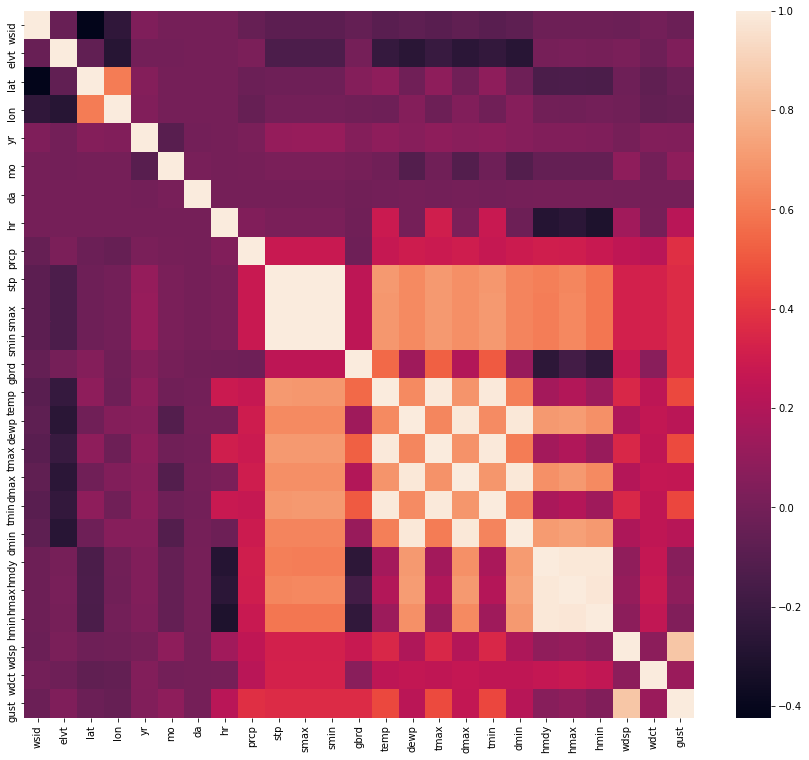

In [13]:
plt.rcParams["figure.figsize"] = [15,13]
sbs.heatmap(data.corr())

## Histogram

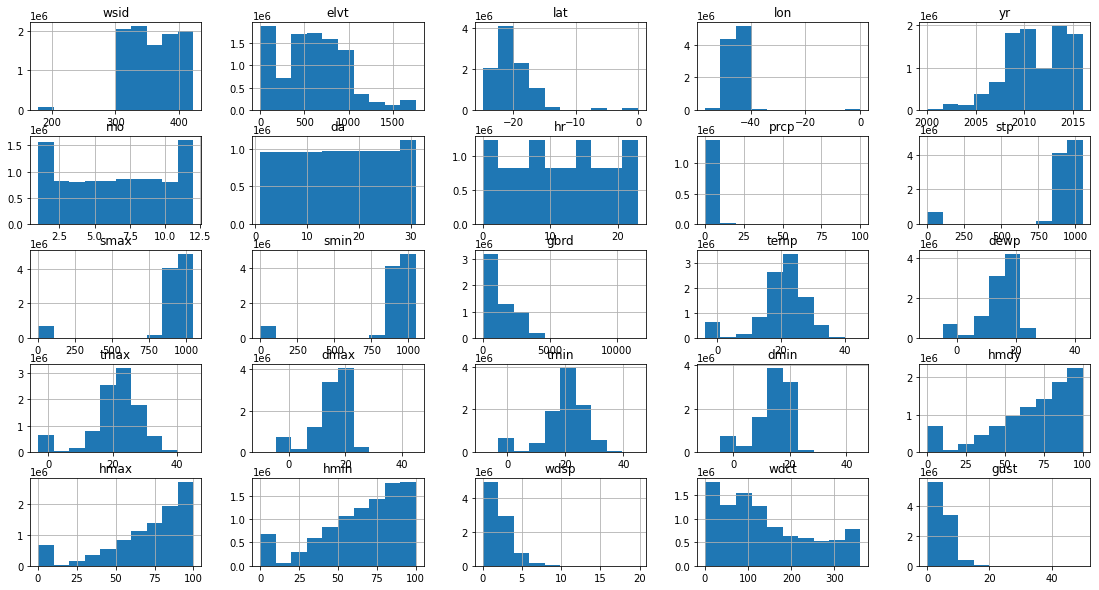

In [14]:
plt.rcParams["figure.figsize"] = [19,10]
data.hist()
plt.show()

---

# Predicting Amount of Precipitation of next 48 hours

## From stp, temp, dewp, hmin, hmax, wdsp of last 12 hours

In [120]:
x_col = ['hr', 'stp', 'temp', 'dewp','hmin', 'hmax', 'wdsp']
y_col = ['prcp']

In [121]:
look_back = 12
predict_forward = 48
N = 100000

X, Y = generate_np_data(data, x_col, y_col, look_back, predict_forward, N, True, False)

train_size = 0.9

X_train, X_test = X[0:int(train_size * len(X))], X[int(train_size * len(X)):]
y_train, y_test = Y[0:int(train_size * len(Y))], Y[int(train_size * len(Y)):]

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
X_train shape (90000, 12, 7)
y_train shape (90000,)


## Using Random Forest, N Trees = 100, 10-fold Cross Validation

In [122]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=8)

In [123]:
s_x = X.shape

result_rf_clas = cross_validate(rf, X.reshape(s_x[0], s_x[1]*s_x[2]), Y, cv=10, scoring=('accuracy', 'f1'))

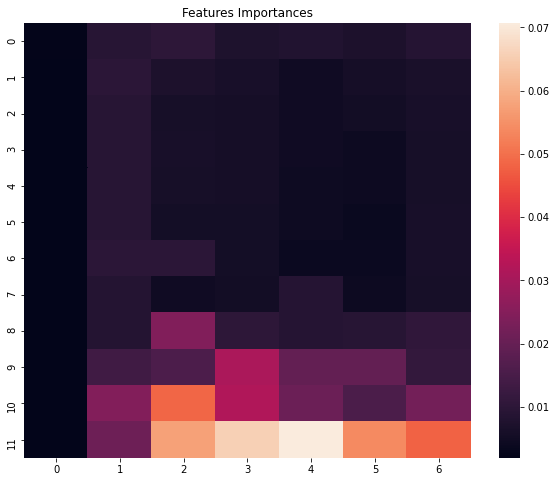

In [503]:
sbs.heatmap(rf.feature_importances_.reshape(s_x[1], s_x[2])).set_title("Features Importances")
plt.show()

### Results

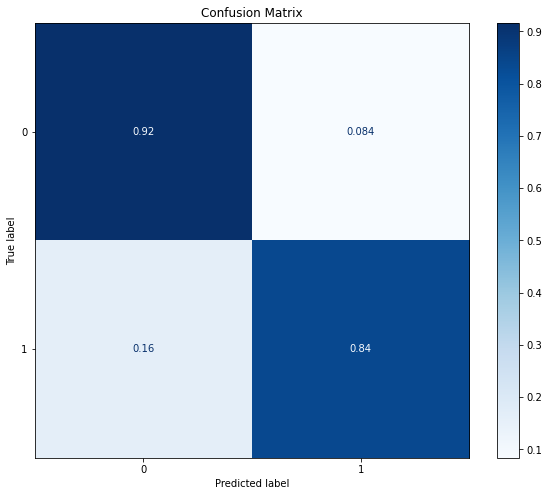

In [504]:
s_x = X_test.shape

plt.rcParams["figure.figsize"] = [10,8]
plot_confusion_matrix(rf, X_test.reshape(s_x[0], s_x[1] * s_x[2]), y_test, normalize='true', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [505]:
y_pred = rf.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      7832
           1       0.73      0.84      0.78      2169

    accuracy                           0.90     10001
   macro avg       0.84      0.88      0.86     10001
weighted avg       0.91      0.90      0.90     10001



## Confidence interval of 95% for acc and f1

In [124]:
result_acc = remove_min_max(result_rf_clas['test_accuracy'])
result_f1 = remove_min_max(result_rf_clas['test_f1'])

print("Accuracy: %0.2f (+/- %0.2f)" % (result_acc.mean(), result_acc.std() * 2))
print("F1 Score: %0.2f (+/- %0.2f)" % (result_f1.mean(), result_f1.std() * 2))

Accuracy: 0.83 (+/- 0.19)
F1 Score: 0.86 (+/- 0.15)


---

## Using Gaussian Naive Bayes

In [125]:
nb = GaussianNB()

In [126]:
s_x = X.shape

result_nb_clas = cross_validate(nb, X.reshape(s_x[0], s_x[1]*s_x[2]), Y, cv=10, scoring=('accuracy', 'f1'), n_jobs=8)

### Results

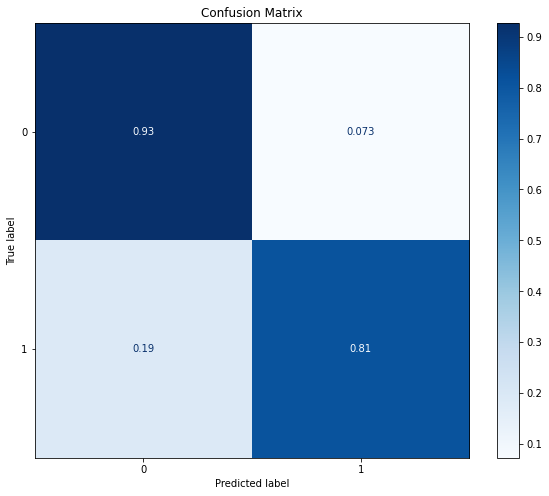

In [508]:
s_x = X_test.shape

plt.rcParams["figure.figsize"] = [10,8]
plot_confusion_matrix(nb, X_test.reshape(s_x[0], s_x[1] * s_x[2]), y_test, normalize='true', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [509]:
y_pred = nb.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      7832
           1       0.76      0.81      0.78      2169

    accuracy                           0.90     10001
   macro avg       0.85      0.87      0.86     10001
weighted avg       0.91      0.90      0.90     10001



## Confidence interval of 95% for acc and f1

In [127]:
result_acc = remove_min_max(result_nb_clas['test_accuracy'])
result_f1 = remove_min_max(result_nb_clas['test_f1'])

print("Accuracy: %0.2f (+/- %0.2f)" % (result_acc.mean(), result_acc.std() * 2))
print("F1 Score: %0.2f (+/- %0.2f)" % (result_f1.mean(), result_f1.std() * 2))

Accuracy: 0.89 (+/- 0.08)
F1 Score: 0.91 (+/- 0.06)


---

## Using LSTM

In [510]:
model = get_model_lstm(look_back, X_train.shape[2])

In [511]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size=64, epochs=10)

Epoch 1/10
1407/1407 [==============================] - 8s 6ms/step - loss: 0.3508 - acc: 0.8729 - val_loss: 0.2518 - val_acc: 0.9075
Epoch 2/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3466 - acc: 0.8735 - val_loss: 0.2427 - val_acc: 0.9084
Epoch 3/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3455 - acc: 0.8736 - val_loss: 0.2343 - val_acc: 0.9061
Epoch 4/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3447 - acc: 0.8738 - val_loss: 0.2427 - val_acc: 0.9081
Epoch 5/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3443 - acc: 0.8738 - val_loss: 0.2307 - val_acc: 0.9062
Epoch 6/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3441 - acc: 0.8741 - val_loss: 0.2388 - val_acc: 0.9076
Epoch 7/10
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3443 - acc: 0.8744 - val_loss: 0.2361 - val_acc: 0.9069
Epoch 8/10
1407/1407 [==============================] - 7s 5ms

In [512]:
y_pred = model.predict(X_test) > 0.5
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7832
           1       0.73      0.92      0.81      2169

    accuracy                           0.91     10001
   macro avg       0.85      0.91      0.87     10001
weighted avg       0.92      0.91      0.91     10001



## Confidence interval of 95% for acc and f1

In [128]:
result_lstm_clas = cross_validate_lstm(X, Y, look_back)

Epoch 1/5
1407/1407 [==============================] - 8s 5ms/step - loss: 0.3408 - acc: 0.8756 - val_loss: 0.3344 - val_acc: 0.8774
Epoch 2/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3362 - acc: 0.8768 - val_loss: 0.3327 - val_acc: 0.8770
Epoch 3/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3355 - acc: 0.8769 - val_loss: 0.3315 - val_acc: 0.8782
Epoch 4/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3338 - acc: 0.8771 - val_loss: 0.3340 - val_acc: 0.8782
Epoch 5/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3334 - acc: 0.8773 - val_loss: 0.3371 - val_acc: 0.8785
Epoch 1/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3386 - acc: 0.8761 - val_loss: 0.3451 - val_acc: 0.8740
Epoch 2/5
1407/1407 [==============================] - 7s 5ms/step - loss: 0.3348 - acc: 0.8772 - val_loss: 0.3410 - val_acc: 0.8742
Epoch 3/5
1407/1407 [==============================] - 7s 5ms/step - 

In [129]:
result_acc = remove_min_max(np.array([row[1] for row in result_lstm_clas]))
result_f1 = remove_min_max(np.array([row[0] for row in result_lstm_clas]))

print("Accuracy: %0.2f (+/- %0.3f)" % (result_acc.mean(), result_acc.std() * 2))
print("F1 Score: %0.2f (+/- %0.3f)" % (result_f1.mean(), result_f1.std() * 2))

Accuracy: 0.88 (+/- 0.003)
F1 Score: 0.90 (+/- 0.003)


---

## Comparison between algorithms

### F1 Score

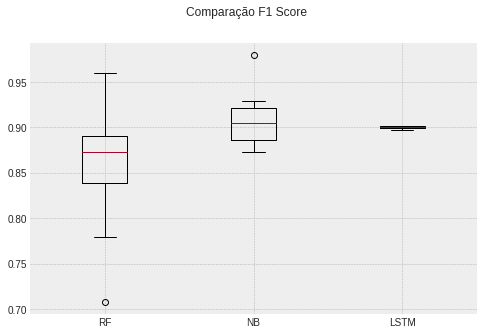

In [141]:
result_f1_rf = remove_min_max(result_rf_clas['test_f1'])
result_f1_nb = remove_min_max(result_nb_clas['test_f1'])
result_f1_lstm = remove_min_max(np.array([row[0] for row in result_lstm_clas]))

results = [result_f1_rf, result_f1_nb, result_f1_lstm]

plt.style.use('bmh')

fig = plt.figure(figsize=(8,5))
fig.suptitle("Comparação F1 Score")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(["RF", "NB", "LSTM"])
plt.show()

### Accuracy Score

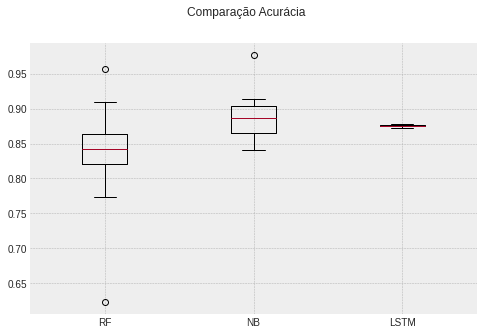

In [143]:
result_acc_rf = remove_min_max(result_rf_clas['test_accuracy'])
result_acc_nb = remove_min_max(result_nb_clas['test_accuracy'])
result_acc_lstm = remove_min_max(np.array([row[1] for row in result_lstm_clas]))

results = [result_acc_rf, result_acc_nb, result_acc_lstm]

plt.style.use('bmh')

fig = plt.figure(figsize=(8,5))
fig.suptitle("Comparação Acurácia")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(["RF", "NB", "LSTM"])
plt.show()

---

# Predicting Wind Speed and Direction of next 6 hours

### From stp, temp, dewp, hmin, hmax, prcp of last 16 hours

In [105]:
x_col = ['hr', 'stp', 'temp', 'dewp', 'hmin', 'hmax', 'prcp']
y_col = ['wdsp', 'wdct']

In [106]:
look_back = 16
predict_forward = 6
N = 100000

X, Y = generate_np_data(data, x_col, y_col, look_back, predict_forward, N, False, False)

train_size = 0.8

X_train, X_test = X[0:int(train_size * len(X))], X[int(train_size * len(X)):]
y_train, y_test = Y[0:int(train_size * len(Y))], Y[int(train_size * len(Y)):]

print("X_train shape", X_train.shape)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
X_train shape (80000, 16, 7)


## Using Random Forest, N Trees = 100

In [107]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=8)

In [108]:
s_x = X.shape

result = cross_validate(rf, X.reshape(s_x[0], s_x[1]*s_x[2]), Y, cv=10, scoring=('r2', 'neg_mean_absolute_error'), n_jobs=8)

In [109]:
result_rf_reg = result

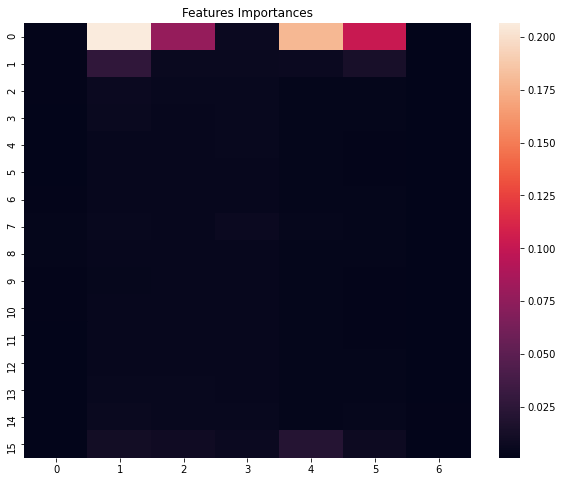

In [518]:
sbs.heatmap(rf.feature_importances_.reshape(s_x[1], s_x[2])).set_title("Features Importances")
plt.show()

### Results

In [519]:
s_x = X_test.shape
y_pred = rf.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))

In [520]:
r2_tree = r2_score(y_test, y_pred, multioutput='raw_values')
mae_tree = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

In [521]:
print("R^2 Score for each value (1 is the best, 0 is the worse):",r2_tree)
print("Mean Absolute Error for each value (less is better):", mae_tree)

R^2 Score for each value (1 is the best, 0 is the worse): [0.59901503 0.55768471]
Mean Absolute Error for each value (less is better): [ 0.35158511 28.63855145]


## Confidence interval of 95% for r2 and mae

In [110]:
result_r2 = remove_min_max(result['test_r2'])
result_mae = remove_min_max(-result['test_neg_mean_absolute_error'])

print("R^2: %0.2f (+/- %0.2f)" % (result_r2.mean(), result_r2.std() * 2))
print("Mean Absolute Error: %0.2f (+/- %0.2f)" % (result_mae.mean(), result_mae.std() * 2))

R^2: 0.44 (+/- 0.32)
Mean Absolute Error: 12.86 (+/- 11.83)


---

## Using Elastic Net

In [111]:
en = ElasticNet(max_iter=5000)

In [112]:
s_x = X.shape

result_en_reg = cross_validate(en, X.reshape(s_x[0], s_x[1]*s_x[2]), Y, cv=10, scoring=('r2', 'neg_mean_absolute_error'), n_jobs=8)

### Results

In [524]:
s_x = X_test.shape
y_pred = en.predict(X_test.reshape(s_x[0], s_x[1] * s_x[2]))

In [525]:
r2_en = r2_score(y_test, y_pred, multioutput='raw_values')
mae_en = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

In [526]:
print("R^2 Score for each value (1 is the best, 0 is the worse):",r2_en)
print("Mean Absolute Error for each value (less is better):", mae_en)

R^2 Score for each value (1 is the best, 0 is the worse): [0.6284566  0.57358701]
Mean Absolute Error for each value (less is better): [ 0.34203335 28.91985739]


## Confidence interval of 95% for r2 and mae

In [113]:
result_r2 = remove_min_max(result_en_reg['test_r2'])
result_mae = remove_min_max(-result_en_reg['test_neg_mean_absolute_error'])

print("R^2: %0.2f (+/- %0.2f)" % (result_r2.mean(), result_r2.std() * 2))
print("Mean Absolute Error: %0.2f (+/- %0.2f)" % (result_mae.mean(), result_mae.std() * 2))

R^2: 0.45 (+/- 0.30)
Mean Absolute Error: 12.74 (+/- 11.19)


---

## Using LSTM

In [532]:
model = get_model_lstm_regression(look_back, X_train.shape[2], len(y_train.shape))

In [533]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size=64, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 7s 5ms/step - loss: 2260.9915 - mse: 2260.9915 - mae: 13.9211 - val_loss: 2179.3816 - val_mse: 2179.3816 - val_mae: 15.0704
Epoch 2/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1444.7032 - mse: 1444.7032 - mae: 11.8595 - val_loss: 1814.7583 - val_mse: 1814.7583 - val_mae: 14.4304
Epoch 3/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1398.0520 - mse: 1398.0520 - mae: 11.9684 - val_loss: 1806.2629 - val_mse: 1806.2629 - val_mae: 15.2301
Epoch 4/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1392.3761 - mse: 1392.3761 - mae: 12.0465 - val_loss: 1783.1744 - val_mse: 1783.1744 - val_mae: 15.1546
Epoch 5/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1389.9233 - mse: 1389.9233 - mae: 11.9591 - val_loss: 1779.1356 - val_mse: 1779.1356 - val_mae: 14.4010
Epoch 6/10
1250/1250 [==============================] - 6s 5ms/step - loss: 1390.3945 - mse: 1390.39

### Results

In [534]:
s_x = X_test.shape
y_pred = model.predict(X_test)

In [535]:
r2_lstm = r2_score(y_test, y_pred, multioutput='raw_values')
mae_lstm = mean_absolute_error(y_test, y_pred, multioutput='raw_values')

In [536]:
print("R^2 Score for each value (1 is the best, 0 is the worse):",r2_lstm)
print("Mean Absolute Error for each value (less is better):", mae_lstm)

R^2 Score for each value (1 is the best, 0 is the worse): [0.60825231 0.56613962]
Mean Absolute Error for each value (less is better): [ 0.35357897 29.03042109]


## Confidence interval 95% for r2 and mae

In [115]:
result_lstm_reg = cross_validate_lstm(X, Y, look_back, cv=10, reg=True)

Epoch 1/5
1407/1407 [==============================] - 8s 6ms/step - loss: 2232.8574 - mse: 2232.8574 - mae: 14.0485 - val_loss: 1508.1456 - val_mse: 1508.1456 - val_mae: 12.1458
Epoch 2/5
1407/1407 [==============================] - 7s 5ms/step - loss: 1489.0111 - mse: 1489.0111 - mae: 12.3606 - val_loss: 1461.2789 - val_mse: 1461.2789 - val_mae: 12.3653
Epoch 3/5
1407/1407 [==============================] - 8s 5ms/step - loss: 1472.1594 - mse: 1472.1594 - mae: 12.3320 - val_loss: 1449.7825 - val_mse: 1449.7825 - val_mae: 12.2018
Epoch 4/5
1407/1407 [==============================] - 8s 5ms/step - loss: 1469.4335 - mse: 1469.4335 - mae: 12.3325 - val_loss: 1455.8263 - val_mse: 1455.8263 - val_mae: 12.2483
Epoch 5/5
1407/1407 [==============================] - 8s 5ms/step - loss: 1466.0028 - mse: 1466.0028 - mae: 12.4716 - val_loss: 1444.1665 - val_mse: 1444.1665 - val_mae: 12.9326
Epoch 1/5
1407/1407 [==============================] - 8s 6ms/step - loss: 2360.5569 - mse: 2360.5569 - m

Epoch 2/5
1407/1407 [==============================] - 7s 5ms/step - loss: 1501.3557 - mse: 1501.3557 - mae: 12.2158 - val_loss: 1505.1505 - val_mse: 1505.1505 - val_mae: 12.4035
Epoch 3/5
1407/1407 [==============================] - 7s 5ms/step - loss: 1469.7589 - mse: 1469.7589 - mae: 12.5356 - val_loss: 1505.6243 - val_mse: 1505.6243 - val_mae: 12.2776
Epoch 4/5
1407/1407 [==============================] - 7s 5ms/step - loss: 1463.8828 - mse: 1463.8828 - mae: 12.5361 - val_loss: 1494.8151 - val_mse: 1494.8151 - val_mae: 13.1213
Epoch 5/5
1407/1407 [==============================] - 7s 5ms/step - loss: 1463.2173 - mse: 1463.2173 - mae: 12.5048 - val_loss: 1488.9879 - val_mse: 1488.9879 - val_mae: 12.7571


In [117]:
result_r2 = remove_min_max(np.array([row[0] for row in result_lstm_reg]))
result_mae = remove_min_max(np.array([row[1] for row in result_lstm_reg]))

print("R^2: %0.2f (+/- %0.2f)" % (result_r2.mean(), result_r2.std() * 2))
print("Mean Absolute Error: %0.2f (+/- %0.2f)" % (result_mae.mean(), result_mae.std() * 2))

R^2: 0.47 (+/- 0.22)
Mean Absolute Error: 12.61 (+/- 0.41)


---

## Comparison between algorithms

### R^2 Score

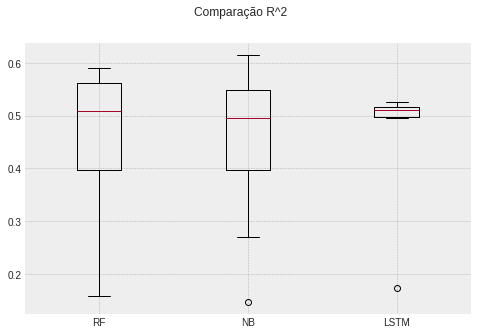

In [149]:
result_r2_rf = remove_min_max(result_rf_reg['test_r2'])
result_r2_en = remove_min_max(result_en_reg['test_r2'])
result_r2_lstm = remove_min_max(np.array([row[0] for row in result_lstm_reg]))

results = [result_r2_rf, result_r2_en, result_r2_lstm]

plt.style.use('bmh')

fig = plt.figure(figsize=(8,5))
fig.suptitle("Comparação R^2")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(["RF", "NB", "LSTM"])
plt.show()

### Mean Absolute Error

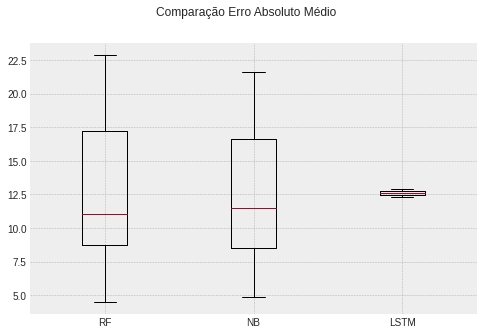

In [151]:
result_mae_rf = remove_min_max(-result_rf_reg['test_neg_mean_absolute_error'])
result_mae_en = remove_min_max(-result_en_reg['test_neg_mean_absolute_error'])
result_mae_lstm = remove_min_max(np.array([row[1] for row in result_lstm_reg]))

results = [result_mae_rf, result_mae_en, result_mae_lstm]

plt.style.use('bmh')

fig = plt.figure(figsize=(8,5))
fig.suptitle("Comparação Erro Absoluto Médio")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(["RF", "NB", "LSTM"])
plt.show()